In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
r = random.Random(2147483647)
r.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182546, 3]) torch.Size([182546])
torch.Size([22840, 3]) torch.Size([22840])
torch.Size([22760, 3]) torch.Size([22760])


In [9]:
words[:n1][:5], words[n1:n2][:5], words[n2:][:5]

(['khole', 'harbour', 'devon', 'baine', 'erisha'],
 ['shterna', 'tyanna', 'sarra', 'malachy', 'zenaya'],
 ['phoenyx', 'christionna', 'bastien', 'niloufar', 'masa'])

In [10]:
C = torch.randn((27, 2))

In [23]:
emb = C[X[:32]]
emb.shape

torch.Size([32, 3, 2])

In [24]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [25]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [26]:
h

tensor([[ 0.9989,  0.8550,  0.6693,  ...,  0.9986, -0.9986, -0.2366],
        [ 0.9997,  0.9603, -0.7415,  ...,  0.9999, -0.7308, -0.1602],
        [ 0.9992,  0.9906, -0.9774,  ...,  1.0000,  0.9986,  0.6506],
        ...,
        [-0.7896, -0.0796,  0.9912,  ..., -0.6622, -0.9910, -0.9892],
        [-0.0458, -0.0474, -0.8244,  ..., -0.7113, -0.1635,  0.1926],
        [ 0.9100,  0.9785, -0.6377,  ...,  1.0000, -0.9737, -0.9221]])

In [27]:
h.shape

torch.Size([32, 100])

In [28]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [29]:
logits = h @ W2 + b2

In [30]:
logits.shape

torch.Size([32, 27])

In [31]:
counts = logits.exp()

In [32]:
prob = counts / counts.sum(1, keepdims=True)

In [33]:
prob.shape

torch.Size([32, 27])

In [34]:
loss = -prob[torch.arange(32), Y[:32]].log().mean()
loss

tensor(17.8203)

In [ ]:
# ------------ now made respectable :) ---------------

In [132]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182546, 3]), torch.Size([182546]))

In [338]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
emb_size = 15
C = torch.randn((27, emb_size), generator=g)
W1 = torch.randn((emb_size * block_size, 512), generator=g)
b1 = torch.randn(512, generator=g)
W2 = torch.randn((512, 256), generator=g)
b2 = torch.randn(256, generator=g)
W3 = torch.randn((256, 27), generator=g)
b3 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2, W3, b3]

In [339]:
sum(p.nelement() for p in parameters) # number of parameters in total

162224

In [340]:
for p in parameters:
  p.requires_grad = True

In [335]:
lre = torch.linspace(-3, 1, 1000)
lrs = 10**lre

In [336]:
# find learning rate
lri = []
lossi = []

for i in range(1000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (256,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h1 = torch.tanh(emb.view(-1, emb_size * block_size) @ W1 + b1)
  h2 = torch.tanh(h1 @ W2 + b2)
  logits = h2 @ W3 + b3 # (32, 27)
  reg_loss = 0.5 * sum([(p**2).mean() for p in parameters])
  loss = F.cross_entropy(logits, Ytr[ix]) + reg_loss
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  lri.append(lre[i])
  lossi.append(loss.item())

#print(loss.item())

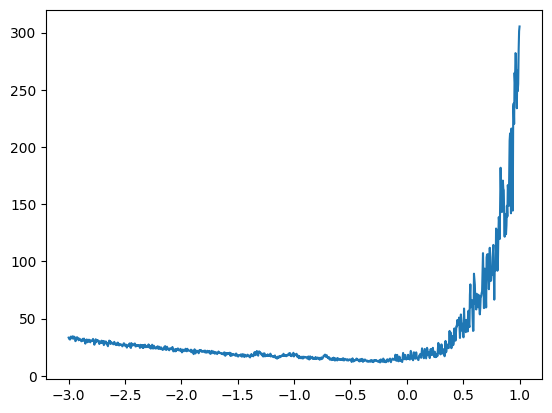

In [337]:
plt.plot(lri, lossi)

In [341]:
lossi = []
for i in range(300000):
  
  # minibatch construct (use same batch sequencies across experiments)
  ix = torch.randint(0, Xtr.shape[0], (256,), generator=g)
  
  # forward pass
  emb = C[Xtr[ix]] # (minibatch size, block size, embeeding size)
  h1 = torch.tanh(emb.view(-1, emb_size * block_size) @ W1 + b1)
  h2 = torch.tanh(h1 @ W2 + b2)
  logits = h2 @ W3 + b3 # (32, 27)
  reg_loss = 0.5 * sum([(p**2).mean() for p in parameters])
  loss = F.cross_entropy(logits, Ytr[ix]) + reg_loss
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.2 if i < 150000 else 0.02
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  lossi.append(loss.log10().item())

#print(loss.item())

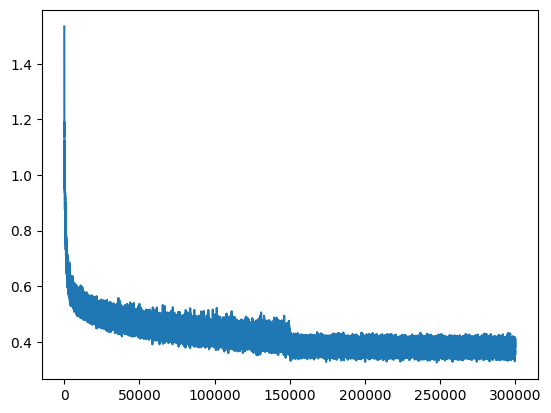

In [342]:
plt.plot(lossi)

In [343]:
emb = C[Xtr] # (Xtr size, 3, 2)
h1 = torch.tanh(emb.view(-1, emb_size * block_size) @ W1 + b1)
h2 = torch.tanh(h1 @ W2 + b2)
logits = h2 @ W3 + b3 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9744, grad_fn=<NllLossBackward0>)

In [344]:
emb = C[Xdev] # (Xdev size, 3, 2)
h1 = torch.tanh(emb.view(-1, emb_size * block_size) @ W1 + b1)
h2 = torch.tanh(h1 @ W2 + b2)
logits = h2 @ W3 + b3 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1024, grad_fn=<NllLossBackward0>)

In [ ]:
# AK original hyperparameters [embeding size: 10, hlayer: 200, init lr: 0.1, decayed lr: 0.01, decay after 100000 iters, epochs: 200000, bs: 32]. Loss: tr=2.1294, dev=2.1858
# lr with loss deeper in find lr [embeding size: 10, hlayer: 200, init lr: 0.2, decayed lr: 0.02, decay after 100000 iters, epochs: 200000, bs: 32]. Loss: tr=2.1194, dev=2.1850
# train longer? [embeding size: 10, hlayer: 200, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 32]. Loss: tr=2.0984, dev=2.1716
# larger embeeding? [embeding size: 15, hlayer: 200, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 32]. Loss: tr=2.0893, dev=2.1738
# larger minibatch? [embeding size: 10, hlayer: 200, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 128]. Loss: tr=2.0447, dev=2.1331
# larger minibatch? [embeding size: 10, hlayer: 200, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256]. Loss: tr=2.0449, dev=2.1295
# larger minibatch? [embeding size: 10, hlayer: 200, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 512]. Loss: tr=2.0529, dev=2.1313
# larger hidden layer? [embeding size: 10, hlayer: 256, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256]. Loss: tr=2.0347, dev=2.1314
# larger hidden layer? [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256]. Loss: tr=1.9835, dev=2.1572
# reg loss [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.001]. Loss: tr=1.9872, dev=2.1477
# reg loss [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.01]. Loss: tr=1.9907, dev=2.1452
# With reg loss established, things tend to improve with larger capacity network
# reg loss [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.1]. Loss: tr=1.9845, dev=2.1002
# reg loss [embeding size: 10, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.5]. Loss: tr=2.0300, dev=2.0951
# reg loss [embeding size: 15, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.5]. Loss: tr=1.9902, dev=2.0797
# reg loss [embeding size: 15, hlayer: 512, init lr: 0.3, decayed lr: 0.03, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.5]. Loss: tr=1.9888, dev=2.0806
# relu [embeding size: 15, hlayer: 512, init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.5]. Loss: tr=2.0206, dev=2.0926

# 2 hiden layers [embeding size: 15, hlayer: [512,256], init lr: 0.2, decayed lr: 0.02, decay after 150000 iters, epochs: 300000, bs: 256, reg strength: 0.5]. Loss: tr=1.9744, dev=2.1024

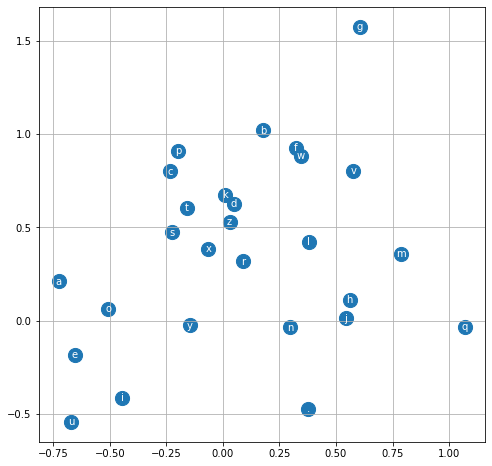

In [710]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [52]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [53]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
nihahalorenyas.
endra.
grazeredotlin.
shyloen.
edeckenna.
artelynn.
sharlin.
shubergyairiel.
kinde.
jelionniella.
uby.
geder.
yuruf.
elsyn.
ajavonnyda.
hil.
salynn.
